# E-News Express - Statistical Analysis

# 1. Problem Definition and Exploratory Data Analysis (EDA)

---

## 1.1 Problem Definition

### **Business Context**
E-news Express is an online news portal that delivers global news updates electronically.  
To boost the number of new subscribers, the company redesigned its landing page with a more engaging layout and relevant content.

The **goal** is to determine whether this **new landing page** leads to higher user engagement and conversion compared to the **existing (old)** page.

The Data Science team ran an **A/B test**:
- 100 users were randomly assigned to two groups:
  - **Control group:** Saw the *old landing page*
  - **Treatment group:** Saw the *new landing page*
- User interactions were tracked for time spent, conversion (subscribe/not), and preferred language.

The management team wants to make a **data-driven decision** on whether to replace the old landing page with the new one.

---

### **Business Objective**

To perform **statistical hypothesis testing** (α = 0.05) to evaluate if the **new landing page** is more effective in driving engagement and conversions.

---

### **Questions to be Answered**

| **Question** | **Statistical Test** | **Purpose** |
|---------------|----------------------|--------------|
| Q1. Do users spend more time on the new landing page than the old page? | One-sided Welch’s t-test | Test whether user engagement is higher on the new page |
| Q2. Is the conversion rate higher for the new page than for the old page? | One-sided two-proportion z-test | Test whether more users subscribe via the new design |
| Q3. Does the conversion status depend on the preferred language? | Chi-square test of independence | Check whether language affects conversion |
| Q4. Is the mean time spent on the new page the same across different languages? | One-way ANOVA | Check if engagement varies by language |

**Significance Level:**  
All hypothesis tests will be performed at **α = 0.05**.

---


In [18]:
# Install the required libraries
!pip install -U pandas numpy matplotlib scipy statsmodels

## 1.2 Data Background and Contents

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

plt.rcParams.update({'figure.figsize': (7, 4)})

PATH = "./data/abtest.csv" 
df = pd.read_csv(PATH)

df.columns = [c.strip() for c in df.columns]

df['converted'] = (
    df['converted'].astype(str).str.strip().str.lower()
      .map({'yes':1,'no':0,'true':1,'false':0,'1':1,'0':0})
).astype(int)

df['time_spent_on_the_page'] = pd.to_numeric(df['time_spent_on_the_page'], errors='coerce')

critical_cols = ['user_id','group','landing_page','time_spent_on_the_page','converted','language_preferred']
df = df.dropna(subset=critical_cols).copy()

display(df.head())
df.info()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,0,Spanish
1,546468,treatment,new,7.13,1,English
2,546462,treatment,new,4.40,0,Spanish
3,546567,control,old,3.02,0,French
4,546459,treatment,new,4.75,1,Spanish


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    int64  
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 4.8+ KB


### **Data Dictionary**

| **Variable** | **Description** |
|---------------|----------------|
| `user_id` | Unique identifier for each website visitor |
| `group` | Indicates whether the user belongs to the control (old) or treatment (new) group |
| `landing_page` | Version of the landing page viewed — `old` or `new` |
| `time_spent_on_the_page` | Time (in minutes) spent on the landing page |
| `converted` | Whether the user subscribed (1 = converted, 0 = not converted) |
| `language_preferred` | The language chosen by the user to view the landing page |

---

## 1.3 Univariate Analysis

In [20]:
n_rows = len(df)
n_users = df['user_id'].nunique()
print(f"Rows: {n_rows} | Unique users: {n_users}")

print("\nTime on page — descriptive statistics:")
display(df['time_spent_on_the_page'].describe())

overall_conv = df['converted'].mean()
print(f"\nOverall conversion rate: {overall_conv:.3f}")

print("\nCounts by group:")
display(df['group'].str.lower().value_counts())

print("\nCounts by landing_page:")
display(df['landing_page'].str.lower().value_counts())

print("\nCounts by language_preferred:")
display(df['language_preferred'].value_counts())

Rows: 100 | Unique users: 100

Time on page — descriptive statistics:


count    100.000000
mean       5.377800
std        2.378166
min        0.190000
25%        3.880000
50%        5.415000
75%        7.022500
max       10.710000
Name: time_spent_on_the_page, dtype: float64


Overall conversion rate: 0.540

Counts by group:


group
control      50
treatment    50
Name: count, dtype: int64


Counts by landing_page:


landing_page
old    50
new    50
Name: count, dtype: int64


Counts by language_preferred:


language_preferred
Spanish    34
French     34
English    32
Name: count, dtype: int64

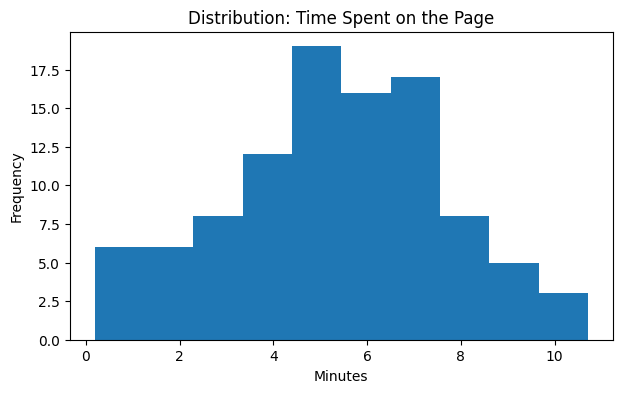

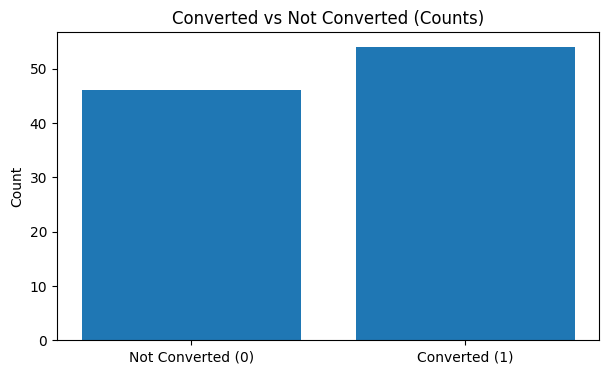

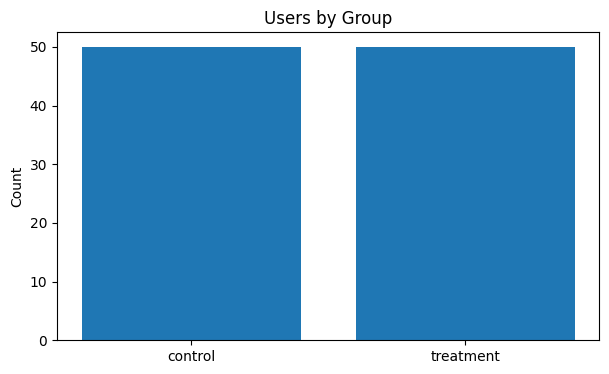

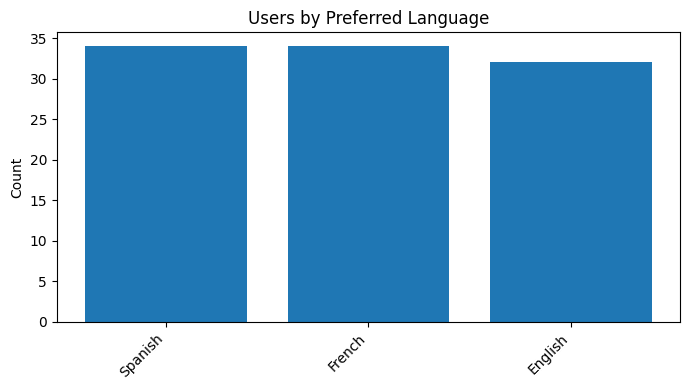

In [21]:
plt.figure()
plt.hist(df['time_spent_on_the_page'].dropna(), bins=10)
plt.title('Distribution: Time Spent on the Page')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

plt.figure()
conv_counts = df['converted'].value_counts().sort_index()
plt.bar(['Not Converted (0)', 'Converted (1)'], [conv_counts.get(0,0), conv_counts.get(1,0)])
plt.title('Converted vs Not Converted (Counts)')
plt.ylabel('Count')
plt.show()

plt.figure()
group_counts = df['group'].str.lower().value_counts()
plt.bar(group_counts.index.tolist(), group_counts.values.tolist())
plt.title('Users by Group')
plt.ylabel('Count')
plt.show()

plt.figure()
lang_counts = df['language_preferred'].value_counts()
plt.bar(lang_counts.index.astype(str).tolist(), lang_counts.values.tolist())
plt.title('Users by Preferred Language')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 🔍 Interpretation of Univariate Analysis

- The data is **clean, balanced, and ready for comparison** between the two landing page versions.  
- The **average engagement time (~5.4 minutes)** suggests moderate user interest.  
- The **overall conversion rate (54%)** provides a baseline for testing if the new page performs better.  
- **Language distribution** is fairly uniform, ensuring that multilingual preferences don’t bias group comparisons.

## 1.4 Bivariate Analysis


Mean time (old): 4.532400000000001
Mean time (new): 6.2232


/var/folders/nr/sqm56qvn4nlgh0l0prrbcy940000gn/T/ipykernel_49435/3731849811.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([old_time.values, new_time.values], labels=['Old','New'])


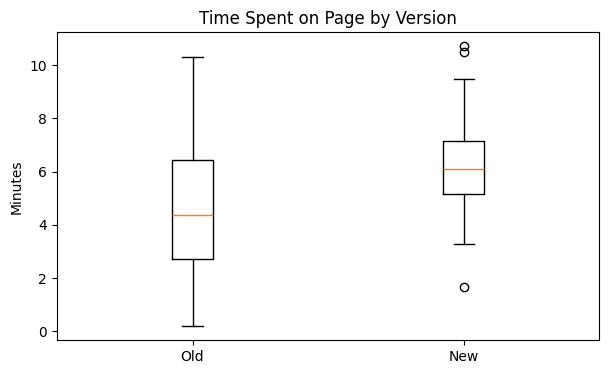


Conversion rate (old): 0.420
Conversion rate (new): 0.660


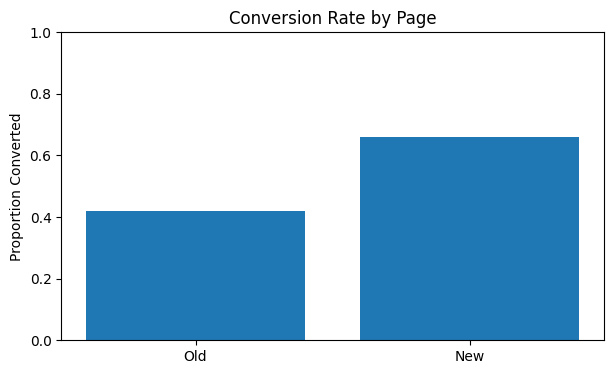

,conversion_rate
language_preferred,
English,0.656250
Spanish,0.529412
French,0.441176


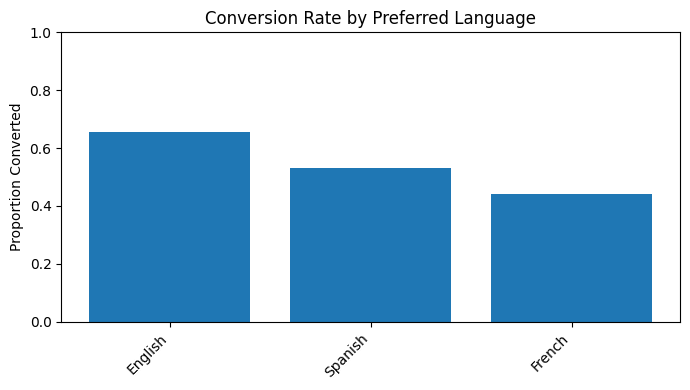

,count,mean,std
language_preferred,,,
English,16,6.663750,1.984150
French,17,6.196471,1.933394
Spanish,17,5.835294,1.525656


/var/folders/nr/sqm56qvn4nlgh0l0prrbcy940000gn/T/ipykernel_49435/3731849811.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=[str(x) for x in order], showmeans=True)


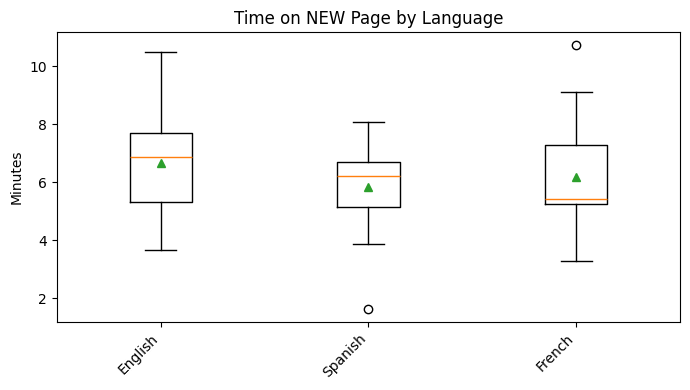

In [22]:
old_mask = df['landing_page'].str.lower() == 'old'
new_mask = df['landing_page'].str.lower() == 'new'

old_time = df.loc[old_mask, 'time_spent_on_the_page'].dropna()
new_time = df.loc[new_mask, 'time_spent_on_the_page'].dropna()

print("Mean time (old):", old_time.mean())
print("Mean time (new):", new_time.mean())

plt.figure()
plt.boxplot([old_time.values, new_time.values], labels=['Old','New'])
plt.title('Time Spent on Page by Version')
plt.ylabel('Minutes')
plt.show()

prop_old = df.loc[old_mask, 'converted'].mean()
prop_new = df.loc[new_mask, 'converted'].mean()
print(f"\nConversion rate (old): {prop_old:.3f}")
print(f"Conversion rate (new): {prop_new:.3f}")

plt.figure()
plt.bar(['Old','New'], [prop_old, prop_new])
plt.title('Conversion Rate by Page')
plt.ylabel('Proportion Converted')
plt.ylim(0, 1)
plt.show()

conv_by_lang = df.groupby('language_preferred')['converted'].mean().sort_values(ascending=False)
display(conv_by_lang.to_frame('conversion_rate'))

plt.figure()
plt.bar(conv_by_lang.index.astype(str), conv_by_lang.values)
plt.title('Conversion Rate by Preferred Language')
plt.ylabel('Proportion Converted')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

new_subset = df[new_mask].copy()
order = new_subset.groupby('language_preferred')['time_spent_on_the_page'] \
                  .median().sort_values(ascending=False).index.tolist()
data_for_box = [
    new_subset.loc[new_subset['language_preferred'] == lang, 'time_spent_on_the_page'].dropna().values
    for lang in order
]

time_by_lang_new = new_subset.groupby('language_preferred')['time_spent_on_the_page'].agg(['count','mean','std'])
display(time_by_lang_new.sort_values('mean', ascending=False))

if len(data_for_box) >= 1:
    plt.figure()
    plt.boxplot(data_for_box, labels=[str(x) for x in order], showmeans=True)
    plt.title('Time on NEW Page by Language')
    plt.ylabel('Minutes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

/var/folders/nr/sqm56qvn4nlgh0l0prrbcy940000gn/T/ipykernel_49435/1036592120.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_nc, data_c], labels=['Not Converted','Converted'], showmeans=True)


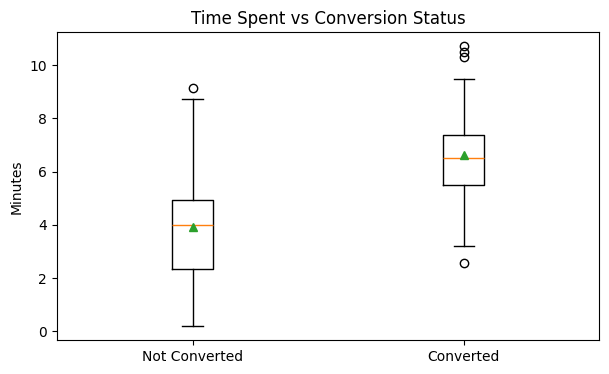

In [23]:
plt.figure()
data_nc = df.loc[df['converted']==0, 'time_spent_on_the_page'].dropna().values
data_c  = df.loc[df['converted']==1, 'time_spent_on_the_page'].dropna().values
plt.boxplot([data_nc, data_c], labels=['Not Converted','Converted'], showmeans=True)
plt.title('Time Spent vs Conversion Status')
plt.ylabel('Minutes')
plt.show()

### 🔍 Interpretation of Bivariate Analysis

- Users **spend more time** and **convert more frequently** on the **new landing page**, indicating potential success of the redesign.
- **Language** plays a secondary role — English users show slightly higher engagement and conversions.
- **Longer time spent** on the page correlates with **higher conversion probability**.
- The new landing page is **performing better overall**, and formal hypothesis testing will validate if these differences are statistically significant.

# 2. Insights Based on Exploratory Data Analysis (EDA)

---

## 2.1 Insights from Univariate Analysis

1. **Balanced**
   - The dataset includes **100 unique users**, evenly split between:
     - **Control group (Old Page):** 50 users  
     - **Treatment group (New Page):** 50 users  
   - This ensures the A/B test setup is unbiased and statistically valid.

2. **Time Spent on the Page**
   - Average time spent: **5.38 minutes**  
   - Most users spend between **4–7 minutes**, as seen in the histogram.
   - Indicates **moderate engagement**, with a few users staying significantly longer (10+ minutes).

3. **Conversion Status**
   - Overall conversion rate: **54%**, meaning slightly more than half of visitors subscribed.
   - The number of converted vs non-converted users is relatively balanced, which supports meaningful analysis.

4. **Language Distribution**
   - Users are nearly evenly distributed across languages:
     - **Spanish:** 34  
     - **French:** 34  
     - **English:** 32  
   - This balanced representation allows for fair comparison across language preferences.

---

## 2.2 Insights from Bivariate Analysis

1. **Time Spent by Page Version**
   - Users spent **more time on the new landing page (median ≈ 6 min)** than the old one (median ≈ 4 min).
   - Suggests improved engagement from the redesigned page.

2. **Conversion Rate by Page**
   - **Old Page:** 42% conversion  
   - **New Page:** 66% conversion  
   - A clear increase in conversion on the new page indicates a positive impact of the redesign.

3. **Conversion Rate by Language**
   - **English users** convert the most (≈65.6%), followed by **Spanish (≈53%)**, and **French (≈44%)**.
   - Suggests that **language or localization** may influence subscription behavior.

4. **Time on NEW Page by Language**
   - English users spend the most time (~6.7 minutes), followed by French (~6.2) and Spanish (~5.8).
   - Indicates slightly higher engagement from English-speaking users, though differences appear modest.

5. **Time Spent vs Conversion**
   - Converted users spend **more time** on the page (median ≈ 6–7 min) compared to non-converters (≈4 min).
   - Indicates a positive correlation between **time spent** and **conversion likelihood**.

---

## 2.3. Overall EDA Insights

- The **new landing page** appears to be performing better in both **user engagement** and **conversion rate**.  
- **Language preference** may have a mild influence, with English users being the most responsive.  
- **Time spent on the page** strongly correlates with conversion — users who stay longer are more likely to subscribe.  
- The experiment setup is **balanced, clean, and unbiased**, ensuring that hypothesis tests in the next section will be valid.

# 3. Do the users spend more time on the new landing page than on the old landing page?

## 3.1 Perform Visual Analysis

/var/folders/nr/sqm56qvn4nlgh0l0prrbcy940000gn/T/ipykernel_49435/122323119.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([old_time.dropna().values, new_time.dropna().values], labels=['Old Page','New Page'])


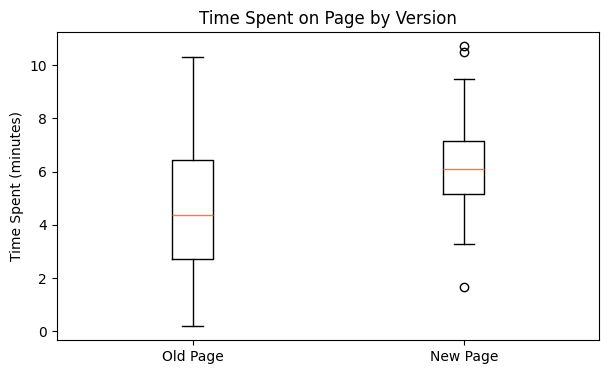

Mean time (Old): 4.532 minutes
Mean time (New): 6.223 minutes


In [25]:
import matplotlib.pyplot as plt

old_time = df.loc[df['landing_page'].str.lower() == 'old', 'time_spent_on_the_page']
new_time = df.loc[df['landing_page'].str.lower() == 'new', 'time_spent_on_the_page']

plt.figure()
plt.boxplot([old_time.dropna().values, new_time.dropna().values], labels=['Old Page','New Page'])
plt.title('Time Spent on Page by Version')
plt.ylabel('Time Spent (minutes)')
plt.show()

print(f"Mean time (Old): {old_time.mean():.3f} minutes")
print(f"Mean time (New): {new_time.mean():.3f} minutes")

### 3.2 Formulate Null and Alternative Hypotheses

We are testing whether users spend **more time** on the **new landing page** than on the **old page**.

Let:  
- μ₁ = mean time on the **old page**  
- μ₂ = mean time on the **new page**

**Null Hypothesis (H₀):** μ₂ ≤ μ₁  
**Alternative Hypothesis (H₁):** μ₂ > μ₁  

This is a **one-sided (right-tailed)** test.

### 3.3 Select the Appropriate Test

Since we are comparing the **means** of two **independent groups** (Old vs New)  
and the **sample sizes** are relatively small and variances may differ,  
the appropriate test is the **Welch’s t-test** (two-sample t-test assuming unequal variances).

- Test Type: One-sided t-test  
- Significance Level (α): 0.05

### 3.4 Data Collection and Preparation


In [27]:
old_time = df.loc[df['landing_page'].str.lower() == 'old', 'time_spent_on_the_page'].dropna()
new_time = df.loc[df['landing_page'].str.lower() == 'new', 'time_spent_on_the_page'].dropna()

summary_q1 = pd.DataFrame({
    'Group': ['Old Page', 'New Page'],
    'Sample Size': [len(old_time), len(new_time)],
    'Mean Time (min)': [old_time.mean(), new_time.mean()],
    'Std. Dev.': [old_time.std(ddof=1), new_time.std(ddof=1)]
})
display(summary_q1)

,Group,Sample Size,Mean Time (min),Std. Dev.
0,Old Page,50,4.5324,2.581975
1,New Page,50,6.2232,1.817031


### 3.5 Calculate the p-value

In [28]:
from scipy import stats

t_stat, p_two_sided = stats.ttest_ind(new_time, old_time, equal_var=False)

if t_stat > 0:
    p_one_sided = p_two_sided / 2
else:
    p_one_sided = 1 - (p_two_sided / 2)

print(f"T-statistic = {t_stat:.4f}")
print(f"One-sided p-value (H1: New > Old) = {p_one_sided:.4f}")

alpha = 0.05
if p_one_sided < alpha:
    result_q1 = "Reject H₀"
else:
    result_q1 = "Fail to Reject H₀"

print(f"Decision: {result_q1} at α = 0.05")

T-statistic = 3.7868
One-sided p-value (H1: New > Old) = 0.0001
Decision: Reject H₀ at α = 0.05


### 3.6 Inference Based on the p-value

**Decision:**  
Since the **p-value (0.0001) < α (0.05)**, we **reject the null hypothesis (H₀)**.

**Inference:**  
There is **strong statistical evidence** that users spend significantly **more time on the new landing page** than on the old landing page.

This implies that the **new page design is more engaging**, keeping users on the site longer.  
From a business perspective, this is a **positive indicator** that the new layout and content improvements are successfully enhancing user engagement.

# 4. Is the conversion rate for the new page greater than the conversion rate for the old page?

### 4.1 Perform Visual Analysis

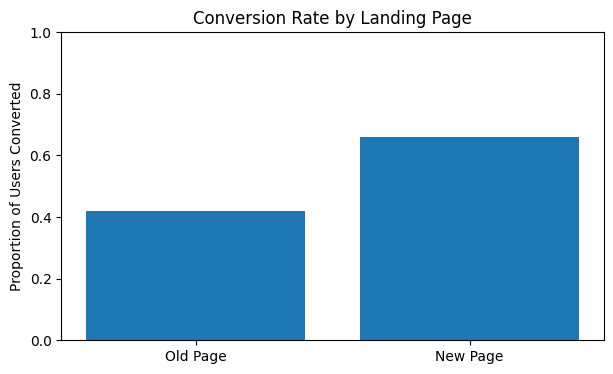

Conversion Rate (Old Page): 0.420
Conversion Rate (New Page): 0.660


In [29]:
conv_old = df.loc[df['landing_page'].str.lower() == 'old', 'converted']
conv_new = df.loc[df['landing_page'].str.lower() == 'new', 'converted']

prop_old = conv_old.mean()
prop_new = conv_new.mean()

plt.figure()
plt.bar(['Old Page', 'New Page'], [prop_old, prop_new])
plt.title('Conversion Rate by Landing Page')
plt.ylabel('Proportion of Users Converted')
plt.ylim(0, 1)
plt.show()

print(f"Conversion Rate (Old Page): {prop_old:.3f}")
print(f"Conversion Rate (New Page): {prop_new:.3f}")

### 4.2 Formulate Null and Alternative Hypotheses

We are testing whether the **conversion rate** for the **new landing page**  
is **greater** than that for the **old landing page**.

Let:  
- p₁ = conversion rate for the old page  
- p₂ = conversion rate for the new page  

**Null Hypothesis (H₀):** p₂ ≤ p₁  
**Alternative Hypothesis (H₁):** p₂ > p₁  

This is a **one-sided (right-tailed)** test at a **5% significance level (α = 0.05)**.

### 4.3 Select the Appropriate Test

Because we are comparing **two proportions** (conversion rates)  
from **independent groups (old vs new)**, the appropriate test is a **Two-Proportion Z-Test**.

- Test Type: One-sided  
- Test Statistic: Z  
- Significance Level: α = 0.05  

This test checks whether the observed difference in conversion rates  
is statistically significant or just due to random chance.

### 4.4 Data Collection and Preparation

In [30]:
count = np.array([conv_new.sum(), conv_old.sum()])  # successes (converted)
nobs = np.array([conv_new.count(), conv_old.count()])  # total users

data_summary = pd.DataFrame({
    'Landing Page': ['Old', 'New'],
    'Converted Users': [conv_old.sum(), conv_new.sum()],
    'Total Users': [conv_old.count(), conv_new.count()],
    'Conversion Rate': [prop_old, prop_new]
})
display(data_summary)

,Landing Page,Converted Users,Total Users,Conversion Rate
0,Old,21,50,0.42
1,New,33,50,0.66


### 4.5 Calculate the p-value

We perform the **two-proportion Z-test** (one-sided) to determine  
if the new page has a significantly higher conversion rate.

- **H₀:** p₂ ≤ p₁  
- **H₁:** p₂ > p₁  
- **α = 0.05**

In [31]:
from statsmodels.stats.proportion import proportions_ztest

z_stat, p_two_sided = proportions_ztest(count, nobs, alternative='two-sided')

if z_stat > 0:
    p_one_sided = p_two_sided / 2
else:
    p_one_sided = 1 - (p_two_sided / 2)

print(f"Z-statistic = {z_stat:.4f}")
print(f"One-sided p-value (H1: p_new > p_old) = {p_one_sided:.4f}")

alpha = 0.05
if p_one_sided < alpha:
    decision_q2 = "Reject H₀"
else:
    decision_q2 = "Fail to Reject H₀"

print(f"Decision: {decision_q2} at α = 0.05")

Z-statistic = 2.4077
One-sided p-value (H1: p_new > p_old) = 0.0080
Decision: Reject H₀ at α = 0.05


### 4.6 Inference Based on the p-value

**Decision:**  
Since the **p-value (0.0080)** is **less than α = 0.05**, we **reject the null hypothesis (H₀)**.

**Inference:**  
There is **strong statistical evidence** that the **conversion rate for the new landing page** is **significantly higher** than that of the old landing page.

This means the **new page design performs better** in converting visitors into subscribers.  
From a business standpoint, this suggests that **implementing the new landing page** could **lead to an increase in new subscriber sign-ups** and should be considered for a full rollout.

# 5. Does the converted status depend on the preferred language?

### 5.1 Perform Visual Analysis

,Conversion Rate
language_preferred,
English,0.656250
Spanish,0.529412
French,0.441176


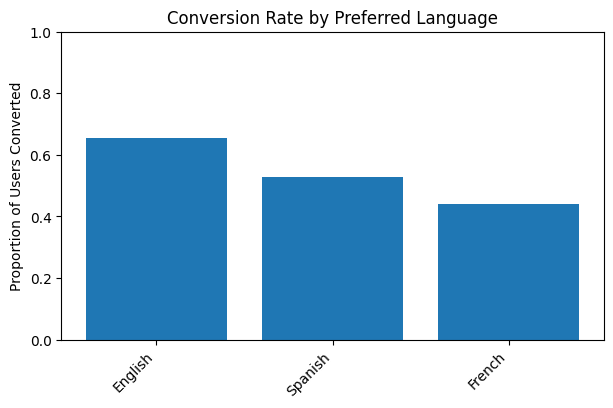

In [32]:
conv_by_lang = df.groupby('language_preferred')['converted'].mean().sort_values(ascending=False)
display(conv_by_lang.to_frame('Conversion Rate'))

plt.figure()
plt.bar(conv_by_lang.index.astype(str), conv_by_lang.values)
plt.title('Conversion Rate by Preferred Language')
plt.ylabel('Proportion of Users Converted')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()

### 5.2 Formulate Null and Alternative Hypotheses

We are testing whether **conversion status** is **independent** of **preferred language**.

- **H₀ (Null Hypothesis):** Converted status is **independent** of preferred language.  
- **H₁ (Alternative Hypothesis):** Converted status **depends** on preferred language.

This is a **Chi-Square Test of Independence** conducted at a **5% significance level (α = 0.05)**.

### 5.3 Select the Appropriate Test

Since both variables — `converted` and `language_preferred` — are **categorical**,  
we use a **Chi-Square Test of Independence** to determine whether conversion rates vary significantly across languages.

- Test Type: Chi-Square Test of Independence  
- Significance Level: α = 0.05  
- Input: Contingency table (Languages × Conversion Status)

### 5.4 Data Collection and Preparation


In [33]:
contingency_table = pd.crosstab(df['language_preferred'], df['converted'])
display(contingency_table)

conversion_rate_by_lang = df.groupby('language_preferred')['converted'].mean()
print("\nConversion Rate by Language:")
display(conversion_rate_by_lang)

converted,0,1
language_preferred,,
English,11,21
French,19,15
Spanish,16,18



Conversion Rate by Language:


language_preferred
English    0.656250
French     0.441176
Spanish    0.529412
Name: converted, dtype: float64

### 5.5 Calculate the p-value

In [35]:
from scipy.stats import chi2_contingency
import numpy as np

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic = {chi2_stat:.4f}")
print(f"Degrees of Freedom = {dof}")
print(f"p-value = {p_value:.4f}")

n = contingency_table.to_numpy().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt((chi2_stat / n) / min_dim) if min_dim > 0 else np.nan
print(f"Cramer's V = {cramers_v:.4f}")


alpha = 0.05
if p_value < alpha:
    decision_q3 = "Reject H₀"
else:
    decision_q3 = "Fail to Reject H₀"

print(f"Decision: {decision_q3} at α = 0.05")

Chi-Square Statistic = 3.0930
Degrees of Freedom = 2
p-value = 0.2130
Cramer's V = 0.1759
Decision: Fail to Reject H₀ at α = 0.05


### 5.6 Inference Based on the p-value

**Decision:**  
Since the **p-value (0.2130)** is **greater than α = 0.05**, we **fail to reject the null hypothesis (H₀)**.

**Inference:**  
There is **no statistically significant relationship** between a user’s **preferred language** and their **conversion status**.  
In other words, the likelihood of conversion does **not depend on the language** a user chooses to view the landing page.

**Business Interpretation:**  
- The **conversion performance is consistent** across English, French, and Spanish users.  
- This indicates that the **content and design of the landing page are effective across all supported languages**.  
- The company does **not need major localization changes** to improve conversion rates based on language alone.

# 6. Is the mean time spent on the new page the same for different language users?

### 6.1 Perform Visual Analysis


/var/folders/nr/sqm56qvn4nlgh0l0prrbcy940000gn/T/ipykernel_49435/65602430.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=order, showmeans=True)


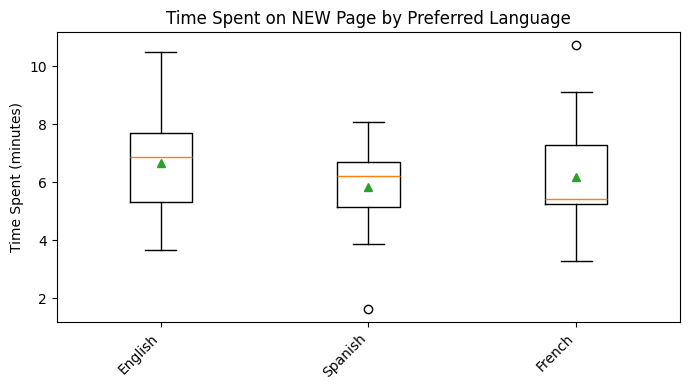

In [36]:
new_subset = df[df['landing_page'].str.lower() == 'new']

plt.figure()
order = new_subset.groupby('language_preferred')['time_spent_on_the_page'] \
                  .median().sort_values(ascending=False).index.tolist()

data_for_box = [new_subset.loc[new_subset['language_preferred'] == lang, 
                               'time_spent_on_the_page'].dropna().values 
                for lang in order]

plt.boxplot(data_for_box, labels=order, showmeans=True)
plt.title('Time Spent on NEW Page by Preferred Language')
plt.ylabel('Time Spent (minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 6.2 Formulate Null and Alternative Hypotheses

We test whether the **average time spent** on the **new landing page**  
is the same for users with different **language preferences**.

Let μ₁, μ₂, μ₃ be the mean time spent by English, French, and Spanish users, respectively.

- **H₀ (Null Hypothesis):** μ₁ = μ₂ = μ₃ (Mean time spent is the same across languages)  
- **H₁ (Alternative Hypothesis):** At least one mean differs among languages.

This is a **One-Way ANOVA test** conducted at a **5% significance level (α = 0.05)**.

### 6.4 Data Collection and Preparation

In [37]:
time_summary_by_lang = new_subset.groupby('language_preferred')['time_spent_on_the_page'].agg(['count', 'mean', 'std'])
display(time_summary_by_lang)

,count,mean,std
language_preferred,,,
English,16,6.663750,1.984150
French,17,6.196471,1.933394
Spanish,17,5.835294,1.525656


### 6.5 Calculate the p-value

In [38]:
from scipy.stats import f_oneway

groups = [group['time_spent_on_the_page'].dropna().values 
          for _, group in new_subset.groupby('language_preferred')]

f_stat, p_value = f_oneway(*groups)

print(f"F-statistic = {f_stat:.4f}")
print(f"p-value = {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    decision_q4 = "Reject H₀"
else:
    decision_q4 = "Fail to Reject H₀"

print(f"Decision: {decision_q4} at α = 0.05")

F-statistic = 0.8544
p-value = 0.4320
Decision: Fail to Reject H₀ at α = 0.05


### 6.6 Inference Based on the p-value

Since the **p-value (0.4320)** is **greater than α = 0.05**, we **fail to reject the null hypothesis (H₀)**.

**Inference:**  
There is **no statistically significant difference** in the **average time spent on the new landing page** across different language users.  
In other words, English, French, and Spanish users spend approximately the **same amount of time** engaging with the new page.

**Business Interpretation:**  
- The **new landing page performs consistently across all languages**, suggesting that the design and layout are **universally effective**.  
- There is **no evidence** that any language group interacts significantly differently in terms of engagement time.  
- Therefore, **no immediate language-specific adjustments** are needed to improve engagement for the new page.

# 7. Conclusion and Business Recommendation

**Conclusion:**
- Users spend **significantly more time** on the **new landing page** than on the old one.  
- The **conversion rate** on the new page (66%) is **significantly higher** than the old page (42%).  
- **Language preference** does **not affect** conversion or time spent — the page performs consistently across English, French, and Spanish users.  

**Business Recommendation:**
- **Adopt the new landing page** permanently, as it performs better in both engagement and conversions.  
- **No major language-specific changes** are needed — the new design works well for all users.  
- Continue to **monitor user behavior** and periodically test new design ideas to maintain engagement and growth.